# Dealing with Images (Enhancing and Segmenting)

## Introduction

This project dives into Encoders-Decoders, where these models are used to edit and generate full images. How these models can be adapted for a wider range of applications such as image denoising or object and instance segmentation. The project will also introduce new concepts like Unpooling, Transposed and Atrous Convolutions layers to the network architecture and its utility for high-dimensional data. Encoders-Decoders can be used for semantic segmentation for driverless cars, where it would help in defining the objects surrounding the vehicle like, roads, other vehicles, people or trees etc. 

## Breakdown of this Project:
- Introduction to Encoders-Decoders. (Notebook 1)
- Encoders-Decoders trained for pixel-level prediction. (Notebook 1)
- Layers such as Unpooling, Transposed and Atrous Convolutions to output high-dimensional data. (Notebook 2)
- FCN and U-Net Architectures for semantic segmentation. (Notebook 3)
- Instance segmentation (extension of Faster-RCNN with Mask-RCNN) (Notebook 4)

## Requirements:
1) Tensorflow 2.0 (GPU prefferably) \
2) CV2 (OpenCV) \
3) Cython \
4) Eigen \
5) PyDenseCRF

For "PyDenseCRF" for windows, LINK: https://github.com/lucasb-eyer/pydensecrf\

It can be installed directly with the following in command prompt or terminal-equivalent: __conda install -c conda-forge pydensecrf__.

If Conda-Forge __does not work__, try: 
- going to: https://www.lfd.uci.edu/~gohlke/pythonlibs/#pydensecrf
- Download: pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl
- Where "cp37" in the filename is the python version of 3.7, make sure you download the correct one.
- Place the downloaded "pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl" file in your working directory drive.
- Open Command Prompt and type in: pip install pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl
- Or if you placed it in a folder or different location: pip install <FILEPATH>\pydensecrf-1.0rc2-cp37-cp37m-win_amd64.whl

## Dataset:
    
The dataset can be obtain from the link: http://www.laurencemoroney.com/rock-paper-scissors-dataset/ or from https://www.tensorflow.org/datasets/catalog/rock_paper_scissors

Rock Paper Scissors is a dataset containing 2,892 images of different types of hands in Rock/Paper/Scissors poses that were 3D-rendered. Each of these images are 300×300 pixels in 24-bit colour.


### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import math
import timeit
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import os
import matplotlib.pyplot as plt

# Run on GPU:
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

In [2]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

# Set to run or not run the code block: for code examples only. (0 = run code, and 1 = dont run code)
dont_run = 0

### GPU Information:

In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 17223983152600862376),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 6586313605, 10622315509631775672)]

### Use RTX_GPU Tensor Cores for faster compute: FOR TENSORFLOW ONLY

Automatic Mixed Precision Training in TF. Requires NVIDIA DOCKER of TensorFlow.

Sources:
- https://developer.nvidia.com/automatic-mixed-precision
- https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#framework

When enabled, automatic mixed precision will do two things:

- Insert the appropriate cast operations into your TensorFlow graph to use float16 execution and storage where appropriate(this enables the use of Tensor Cores along with memory storage and bandwidth savings). 
- Turn on automatic loss scaling inside the training Optimizer object.

In [4]:
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

EXAMPLE CODE: 

In [5]:
# # Graph-based example:
# opt = tf.train.AdamOptimizer()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# train_op = opt.miminize(loss)

# # Keras-based example:
# opt = tf.keras.optimizers.Adam()
# opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)
# model.compile(loss=loss, optimizer=opt)
# model.fit(...)

### Use RTX_GPU Tensor Cores for faster compute: FOR KERAS API

Source:
- https://www.tensorflow.org/guide/keras/mixed_precision
- https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/experimental/Policy

In [6]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

In [7]:
# # Set for MIXED PRECISION:
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

### To run this notebook without errors, the GPU will have to be set accordingly:

In [8]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 1 - Introduction to Convolutional Encoders-Decoders:

Similar to the Fully connected network, the Encoder-Decoder models can also be kitted out with Convolutional and Pooling layers, although with some variables of these, to be structured in a way to form the __Deep Auto-Encoders (DAEs)__. These kinds of architecture can be used for more complex tasks such as __Super-Resolution__ of images. Before moving onto making the network in TensorFlow, some of the basics will need to be covered first and these are:

1) Unpooling. \
2) Transposing. \
3) Dilating.

These can also be grouped together and be called __Reversed Operations__.

## 2 - Reversed Operations: Unpooling, Transposing and Dilating.

In previous notebooks, the convolutional layers were introduced to extract high-level features of the neural network, and that the pooling layers would down-sample the data to extract semantically rich features that are compact. In a way, Convolutional Neural Networks' feature extractors are like encoders. The part that differs from a CNN is on the decoding end, where it would decode these lower dimensional features into full images. To achieve this, reversed operations would  be utilised. The decoder part of the network would use __transposed convolutions__, __dilated convolutions__ and __unpooling__. 

### 2.1 - Transposed Convolutions: a.k.a Fractionally Strided Convolutions

The convolution operation will be discussed here once more for reference and to be compared with its reversed operation. For Convolutions, it takes in hyperparameters that are following:

- Kernel Size, k.
- Input Depth, D.
- Number of Kernels, N.
- Padding, p.
- Stride, s. 

Where for an input tensor with the shape Height x Width x Depth, the output tensor will have the shape $H_{o}$ and $W_{o}$ as:

$$ H_{o} = \frac{H - k + 2p}{s} + 1 $$ and $$ W_{o} = \frac{W - k + 2p}{s} + 1 $$

From the Decoder's perspective, $H_{o}$ and $W_{o}$ will be its input. Therefore for a given input feature map with the shape of $Height_{o}$, $Width_{o}$ and $N$ (Number of Kernels), a __reversed operation__ will be performed to recover the tensor shape, that is defined as the following:

$$ H = (H_{o} - 1) * s + k - 2p$$ and $$ W = (W_{o} - 1) * s + k - 2p$$

##### To demonstrate a simple transposed convolution, an example is shown below:

<img src="Description Images/Transposed Convolution.PNG" width="750">

Image Ref -> http://d2l.ai/chapter_computer-vision/transposed-conv.html

From the above, it can be seen that some of the elements of the upsampled feature maps are overlapping, these are resolved by simple addition of the the overlapping elements. On other words, the transposed convolutional layers mirrors the standard convolutions to increase the spatal dimensions of the feature maps while utilising trainable filters for its convolutions over the input feature tensor. As this operation is quite similar to the standard convolution, there won't be much performance hit on the overall computation. __Overall, transposed convolutions approximates and tries to return the tensors back to the original shape, it does not revertit back to the original input tensor.__ 

These can be called onin TensorFlow with: "tf.keras.layers.Conv2DTranspose()" or "tf.layers.conv2d_transpose()"

Another good example can be found with the link: https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8

### 2.2 - Unpooling:

In CNNs, pooling operations were used subsequently after each convolutions, although as the name suggests, unpooling would be the reverse of max-pooling or average pooling techniques, however, this is not the case. Taking the example of max-pooling on the original output feature tensor, performing the operation in reserve is impossible as it is inherent in the way the operation was conducted. Recovering the original input tensor is not possible. Unpooling would then be an operation that approximates the inversion of the tensor where it would be in terms of spatial sampling. 

##### Below shows the Unpooling Operation:

<img src="Description Images/Unpooling.PNG" width="550">

Image Ref -> https://abenbihi.github.io/posts/2018-06-tf-unpooling/

From the diagram above, it can be seen that the location of the max-values remained in the same position as with the original, where the rest of the elements were filled with zeros. The positions of these values are determined by the pooling masks. Similar to other pooling layers, the unpoling operation are also fixed and considered untrainable operations. The diagram below shows the operation with a different tensor, but the concept applies.

<img src="Description Images/Mask_Unpooling.PNG" width="550">

Image Ref -> https://abenbihi.github.io/posts/2018-06-tf-unpooling/

The more commonly used unpooling operation other than max-unpooling is the __Average-unpooling__ operation (or known as __Upsampling__ or __Resize__). Similar to average-pooling operation but in reverse, it takes each of the tensor values and copies it into a k by k region. This is demonstrated in the diagram below.

<img src="Description Images/Upsampling_Resizing.PNG" width="550">

Image Ref -> https://arxiv.org/pdf/2004.04892.pdf

In TensorFlow, it can be called with: "tf.keras.layers.UpSampling2D()" and "tf.image.resize()", where the lateer is a wrapper which will need to takin a parameter "method = tf.image.ResizeMethod.NEAREST_NEIGHBOR".

### 2.3 - Dilated Convolutions: a.k.a Atrous Convolutions.

The dilated convolutions serves the purpose of increasing the receptive field of the convolutions while keeping the spatial dimensionality of the data. It takes in a hyperparameter "d" as the dilation to be applied to the kernels. Note that "Transposed convolution" also has its own implementation of dilation but it is implemented differently. 

##### The operation can be seen in the diagram below:

<img src="Description Images/Dilated_Conv.PNG" width="550">

Image Ref -> https://www.semanticscholar.org/paper/Deep-Dilated-Convolution-on-Multimodality-Time-for-Xi-Hou/afadf82529110fadcbbe82671d35a83f334ca242/figure/1

In TensorFlow, it can be called with: "tf.layers.conv2d()" and "tf.keras.layers.Conv2D()" where both will take in a hyperparameter "dilation_rate".

## 3 - Fully Convolutional Networks & U-Net:

The Fully Convolutional Networks (FCNs) & U-Net are models that are used for Deep Auto-Encoders. 

### 3.1 - Fully Convolutional Networks:

The FCN models are mostly based on the VGG-16 architecture, where the CNN part of the model will extract the features from the input images during training, the difference here is that the final dense layers were replaced with 1x1 convolutions and extended with upsampling blocks. This essentially transforms the model into an Encoder-Decoder network. 

##### Below shows the Overall FCN model with its three variants:

<img src="Description Images/FCN_variants(VGG16).PNG" width="650">

Image Ref -> http://deeplearning.net/tutorial/fcn_2D_segm.html

In more detail, the model consists of 5 convolutional blocks that originates from the VGG-16 architecture to extract the features from the input images to feaature maps, it divides the spatial dimensions by 2 after each block. When arriving at the decoding stage at "conv6", the fully connected layer were replaced by convolutional (1x1) blocks, subequently another final layer is placed and this is the transposed convolution layer for the purposes of upsampling the data back into the original input shape. 

<img src="Description Images/FCN_variants(VGG16)_breakdown.PNG" width="650">

Image Ref -> http://deeplearning.net/tutorial/fcn_2D_segm.html

From the above, it can also be seen that there are __3 variants of FCNs__, and these are FCN-32s, FCN-16s, and FCN-8s. These models mainly differ in the spatial precision of their output. The 3 variants exists because it was found out during testing that the output of FCN-32s produces very coarsed results (J. Long et al.). 

##### Below shows the Output of FCN-32s:

<img src="Description Images/FCN32_Output.PNG" width="150">

Image Ref -> http://deeplearning.net/tutorial/fcn_2D_segm.html

The reason for this was that the stride (= 32) of the final layer limited the scale of the details, where although it was contextually rich but lacked in spatial definition. The creators then proposed techniques to solve this problem.

##### Below shows the difference in final operations applied to achieve better results, producing these 3 variants:

<img src="Description Images/FCN_variants(VGG16)_breakdown2.PNG" width="650">

Image Ref -> http://deeplearning.net/tutorial/fcn_2D_segm.html

These 3 architectures differs in the stride applied in the last convolution, and with the addition of skip connections to obtain the output segmentation maps. IN FCN-16s, the last layer of FCN-32s are replaced with a new transposed layer with Stride = 2 (essentially added after "conv 5 + pool 5"), in order to produces the feature maps that are of the same dimensions as the 4th convolutional layer (conv 4 + pool 4). This is so that when a skip connection is used, feature maps from both tensors (conv 5_transposed and with conv 4) can be merged together by element-wise additon. The resultant output is a scaled back tensor that has the original input shape, where it is applied with another transposed convolution with Stride = 16. The same is done for FCN-8s, except rather than merging with convolution block 4, it was doen with convolutional block 3.

With these changes to the architecture, the output will also differ in coarseness.

##### Below shows the Output of the FCN-32s, 16s and 8s:

<img src="Description Images/FCN_All_Output.PNG" width="450">

Image Ref -> http://deeplearning.net/tutorial/fcn_2D_segm.html

Source: 
- J. Long, E. Shelhamer and T. Darrell, "Fully convolutional networks for semantic segmentation," 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Boston, MA, 2015, pp. 3431-3440, doi: 10.1109/CVPR.2015.7298965.


### 3.2 - U-Net:

Another type of network that can be employed for __semantic segmentation__ is U-net. It is aptly named so due to the look of the architecture. It is composed of multiple blocks of both contractive encoder and expansive decoder. The encoder segment works to increase the features' depth and reduces the spatial dimensions, whereas the decoder works to recover the image resolution. Comparing U-net to FCN-8s, there are tw main differences:

1) U-net's architecture is symmetric. \
2) It utilises skip connections to connect all the encoding blocks to the decoder blocks. 

These skip connections were implemented differently compared to FCNs where it uses the concatenation operator along the channel axis rather than addition. The decoding blocks benefits from these skip connections as it provides both the contectual information from the preceding block as well as the location information from the encoding blocks. 

##### Below shows the U-net architecture:

<img src="Description Images/U_net.PNG" width="450">

Image Ref -> https://heartbeat.fritz.ai/deep-learning-for-image-segmentation-u-net-architecture-ff17f6e4c1cf

From the above, U-Net architecture is separated in 3 parts where:
1) The contracting/downsampling path. \
2) Bottleneck. \
3) The expanding/upsampling path.

The encoders are on the left while the decoders are on the right (Highlighted in RED). Highlighted in ORANGE are the skip connections that connects the encoders to the decoding block where it will be concatenated. 

#### For the Contracting path:
It is composed of 4 blocks, where each of the block is composed of:

- 3x3 Convolution Layer + activation function (with batch normalization)
- 3x3 Convolution Layer + activation function (with batch normalization)
- 2x2 Max Pooling

It can be seen that the number of feature maps doubles at each pooling. It starts with 64 feature maps for the 1st block, 128 for the 2nd block and so on. The contracting path serves the purpose of capturing the context from the input image to do segmentation. Then this coarse contextual information will be transfered to the Expanding path by means of the skip connections.

#### For the Bottleneck:
This sits between the contracting and expanding paths. The bottleneck is built from simply 2 convolutional layers (with batch normalization), with dropout.

#### For the Expanding path:
It is also composed of 4 blocks, where each of these blocks is composed of:

- Deconvolution layer with stride 2
- Concatenation with the corresponding cropped feature map from the contracting path
- 3x3 Convolution layer + activation function (with batch normalization)
- 3x3 Convolution layer + activation function (with batch normalization)

The expanding path serves the purpose to enable precise localisation information to be combined with the contextual information from the contracting path.

##### Below demonstrates how the Encoder's contracting and Decoder's expanding paths:

<img src="Description Images/U_net_expand_contracting.PNG" width="650">

Image Ref -> https://heartbeat.fritz.ai/deep-learning-for-image-segmentation-u-net-architecture-ff17f6e4c1cf

## 4 - Tensorflow Implementation:

This next section will venture into experimenting with FCNs and U-net models to ttaackle the task of __Image Super Resolution__. Essentially, the model should be able to remove artifacts that were caused by downsampling and to recover the details lost during the process. 

NOTE: It should also be noted that for a network to train for __Super-Resolution__ tasks, it can only perform will when trained and applied on specific categories of images, mean that the images should have common features that CNNs can utilise and exploit. 

NOTE: Utilising these models should be computationally complex and will require GPU to complete the training and task. Avoid running on CPU.

## 4.1 - Setting up the Hyperparameters:

In [9]:
batch_size = 512
nb_epochs = 300

#### Up-Scaling Factor:

This hyperparameter will be used to upscale the images.

In [10]:
scale_factor = 4

## 4.2 - Dataset preparation:

As mentioned, the dataset that will be used with the model is the __Rock-Paper-Scissors__ dataset. Again, the task is for the network to get trained on recoving the lost in dettails of these images. 

To do this, an input pipeline will be set up to train the model to upsample the hand images. 

##### NOTE: if running on Anaconda, the TensorFlow-Datasets at this time was version 1.2, which is the outdated version, so the package will need to be updated to version 3.1 (or latest). Use one of the following "PIP" commands and restart the notebook once it is done updating.

In [11]:
# !pip uninstall -y tensorflow_datasets 
# !pip uninstall -y tfds-nightly

In [12]:
# !pip install tfds-nightly
# !pip install tensorflow-datasets
# !pip install git+https://github.com/tensorflow/datasets.git@master#egg=tensorflow_datasets

In [13]:
# Import the required library:
import tensorflow_datasets as tfds

print(tfds.__version__)

3.1.0


In [14]:
# Load in the Dataset:
hands_builder = tfds.builder("rock_paper_scissors")
hands_builder.download_and_prepare()

print(hands_builder.info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



#### Let's check out the dataset:

In [15]:
# Import the required library:
from plotting_utilities import plot_images_inGrid

D:\anaconda3\envs\Py37Work\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


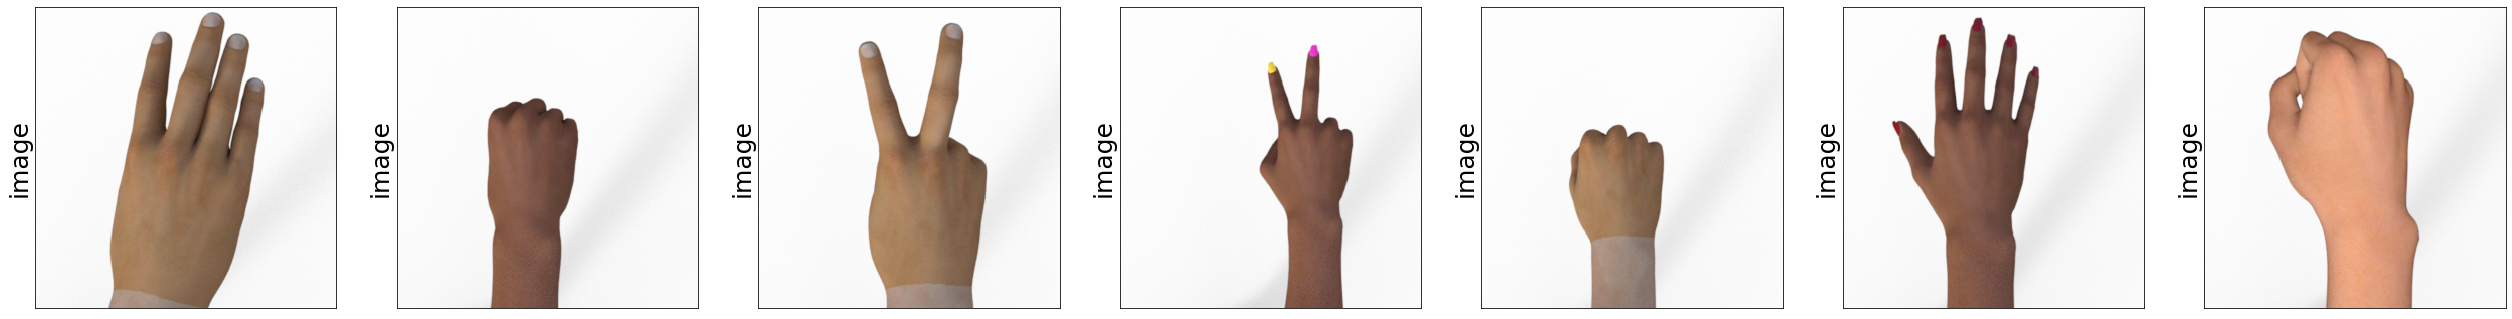

In [16]:
# Number of Images to plot:
nb_show = 7

# Batch the images:
hands_val_set = hands_builder.as_dataset(split=tfds.Split.TEST).batch(nb_show)
hands_val_set_iter = hands_val_set.skip(1).__iter__()
batch = next(hands_val_set_iter)

# Plot:
fig = plot_images_inGrid(images = [batch['image'].numpy()],
                         titles=['image'],
                         transpose=True)
fig.show()

### 4.2.1 - Define the Input Pipeline for the Dataset (tf.data):

Now, that the dataset have been load in, this next stage is to create an __Input Pipeline__ to process the images in the dataset. The input pipeline process will be composed of the following:

1) Instantiate a "tf.data.Dataset" of the images with "tensorlow-datasets" (as seen above). \
2) Apply some random augmentations to the training images, these will include brightness and saturation, random cropping and scaling and some resizing. \
3) Duplicating the images and downscales one in each pair, where this sets the downscaled images as the input and the original images as the model's targets. \
4) Set up the images in batches if the batch_size value is more than 1, and it will repeat the process according to the number of epochs.

In [17]:
# Import the required library:
import functools

In [18]:
def _prepare_data_func(features, scale_factor=4, augment=True, return_batch_as_tuple=True, seed=None):
    """ This builds a pre-processing function to resize the image into the expected dimensions and allows for an
        optional transformation of the images such as augmentations.
    Parameters:
        - features, is the input data.
        - scale_factor, is the Scaling factor to apply.
        - augment, is a Flag to apply random transformations to the input images.
        - return_batch_as_tuple, is an optional Flag to return the batch data as tuple rather than a dict.
        - seed, is the seed number for random operations, allows for reproducibility.
    Returns:
        - returns processed features.
    Notes:
        - Tensorflow-Dataset returns batches as feature dictionaries, that are expected by Estimators.
        - To train for Keras models, it is better to return the batch content as tuples.
    """
    # To train Keras models, it is more better(recommended) to return the batch content as tuples.
    # Convert TF-dataset feature dictionaries into Tuples:
    image = features['image']

    # Convert the image data type to "float32" and normalise the data to a range between "0 and 1":
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Compute the scaled down images:
    original_shape = tf.shape(image) # shape = [1 7 300 300 3]
    original_size = original_shape[-3:-1] # shape = [300 300]
    
    scaled_size = original_size // scale_factor # size = [75 75]
    
    # For caution-sake, if the original input dimensions were not multiplied by the "scale_factor",
    # the original images will be resized accordingly:
    original_size_mult = scaled_size * scale_factor # Size = [300 300]

    # Data Image Augmentation:
    if augment:
        
        original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])  # Outputs: ([300 300], [3])
        
        # for Batched data:
        if len(image.shape) > 3:
            original_shape_mult = ([tf.shape(image)[0]], *original_shape_mult) # Outupts: ([1], [300 300], [3])
        original_shape_mult = tf.concat(original_shape_mult, axis = 0)
        
        # Apply random horizontal flip::
        image = tf.image.random_flip_left_right(image)

        # Apply Brightness and Saturation changes:
        image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed)
        image = tf.clip_by_value(image, 0.0, 1.0)  # this keeps the pixel values in check.

        # Apply random resizing and cropping back to expected image sizes:
        random_scale_factor = tf.random.uniform(shape=[1], minval=1., maxval=1.2, dtype=tf.float32, seed=seed)

        scaled_height = tf.cast( tf.multiply(tf.cast(original_size[0], tf.float32), random_scale_factor), tf.int32 )
        scaled_width = tf.cast( tf.multiply(tf.cast(original_size[1], tf.float32), random_scale_factor), tf.int32 )
        scaled_shape = tf.squeeze( tf.stack([scaled_height, scaled_width]) )

        image = tf.image.resize(image, scaled_shape)
        image = tf.image.random_crop(image, original_shape, seed=seed)
        
    # Generate data pair for the Super-Resolution Task: downscaled image + its original version
    image_downscaled = tf.image.resize(images= image, size= scaled_size)
    
    # For caution-sake, if the original input dimensions were not multiplied by the "scale_factor",
    # the original images will be resized accordingly: using "original_size_mult" from above.
    original_size_mult = scaled_size * scale_factor
    image = tf.image.resize(images= image, size= original_size_mult)
    
    features = (image_downscaled, image) if return_batch_as_tuple else {'image': image_downscaled,
                                                                        'label': image}

    return features

In [19]:
def get_dataset(phase='train', scale_factor=4, batch_size=32, nb_epochs=None, shuffle=True, augment=False, return_batch_as_tuple=True, seed=None):
    """ This builds a function to process and get the dataset. Dataset is Rocks-Papers-Scissors.
     Parameters:
         - phase, is the current phase of data processing, either 'train' or 'test'.
         - scale_factor, is the scale factor for the task.
         - batch_size, is the batch_size.
         - nb_epochs, is the number of epochs.
         - shuffle, is an optional FLag to shuffle the dataset (default=True).
         - augment, is an optional Flag to augment the images.
         - return_batch_as_tuple, is a Flag to return the batched data as a tuple rather than a dict.
         - seed, is the seed number for random operations, allows for reproducibility.
    :return:
        - returns an Iterable Dataset (processed).
    """

    # Detect Early Problems with dataset:
    assert(phase == 'train' or phase == 'test')

    # Instantiate the data preparation function:
    prep_dat_func = functools.partial(_prepare_data_func, 
                                      scale_factor=scale_factor, 
                                      augment=augment,
                                      return_batch_as_tuple=return_batch_as_tuple, 
                                      seed=seed)

    # Take the data as Train or Test:
    hands_data = hands_builder.as_dataset(split=tfds.Split.TRAIN if phase == 'train' else tfds.Split.TEST)
    hands_data = hands_data.repeat(nb_epochs)

    # Data Shuffling:
    if shuffle:
        hands_data = hands_data.shuffle(hands_builder.info.splits[phase].num_examples, 
                                        seed=seed)
       
    # Split the dataset into batched images:
    hands_data = hands_data.batch(batch_size)
    
    # Apply the data prep func to the dataset: 
    hands_data = hands_data.map(prep_dat_func, 
                                num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    # Set to prefetch the data: for improved performance.
    hands_data = hands_data.prefetch(1)

    return hands_data

Now that the pipeline functions for processing the image data is done, it can be applied to the dataset. 

### 4.2.2 - This stage will then initialise the training and validation dataset with the input pipeline:

In [20]:
# Define the number of images:
nb_train_imgs = hands_builder.info.splits['train'].num_examples
nb_val_imgs = hands_builder.info.splits['test'].num_examples

# Define the number of steps per epoch:
train_steps_per_epoch = math.ceil(nb_train_imgs / batch_size)
val_steps_per_epoch = math.ceil(nb_val_imgs / batch_size)

# Define the Input Shape:
input_shape = hands_builder.info.features['image'].shape

# Process the Dataset: Training and Validation.
train_hands_dataset = get_dataset(phase='train',
                                  scale_factor=scale_factor,
                                  batch_size=batch_size,
                                  nb_epochs=nb_epochs,
                                  shuffle=True,
                                  augment=True,
                                  return_batch_as_tuple=True,
                                  seed=Seed_nb)

val_hands_dataset = get_dataset(phase='test',
                                scale_factor=scale_factor,
                                batch_size=batch_size,
                                nb_epochs=1,
                                shuffle=False,
                                augment=False,
                                return_batch_as_tuple=True,
                                seed=Seed_nb)



### 4.2.3 - Check if the Processing completed on the dataset is working well:

To ensure that the implemented pipeline performs as expected, it is good to check and visualise the batched processed data,in terms of downsampling effect. To compare the orignal and processed images side by side, these images will need to be rescaled back to the original dimensions.

D:\anaconda3\envs\Py37Work\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


PSNR score for each image pair: [28.435432 31.656214 30.73105  30.303377 33.07742  27.908255 31.461094]


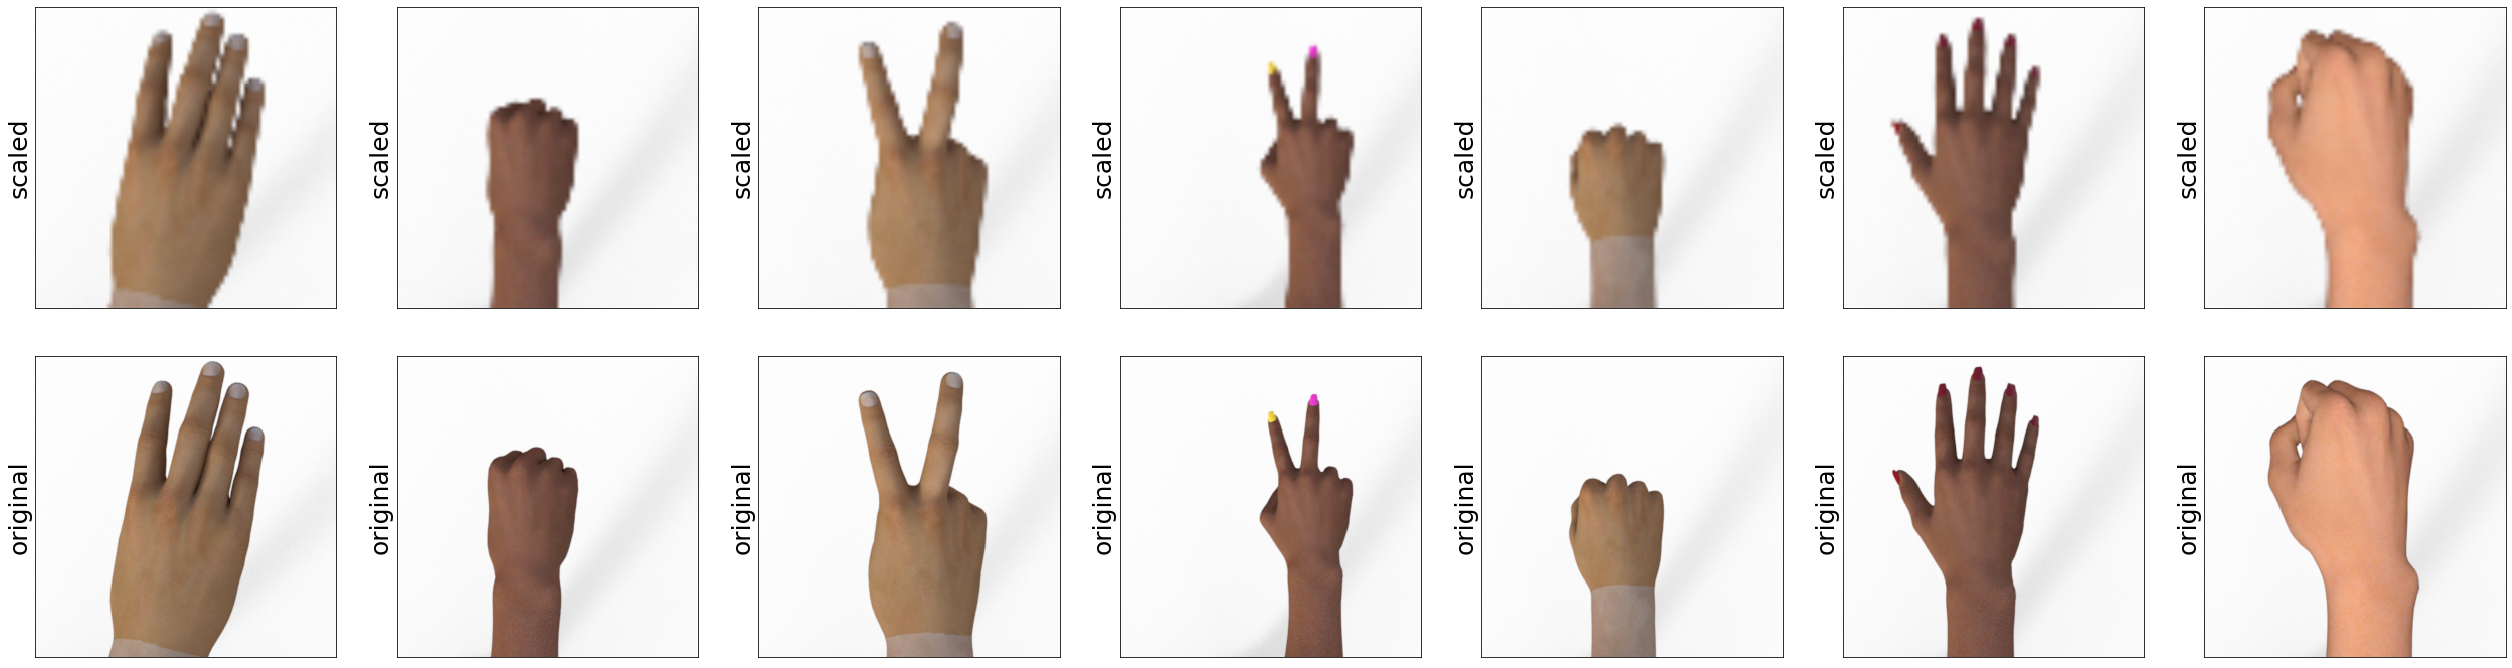

In [21]:
# Recall, that the processed output above is a tuple of (image_downscaled, image):

# Create an Iterable object with the batched images: taking the validation set.
val_hands_dataset_show = val_hands_dataset.take(1)

val_hands_dataset_show_iter = val_hands_dataset_show.__iter__()
val_images_input, val_image_target = next(val_hands_dataset_show_iter)

# Selecting the number of input and target validation images to show:
nb_show_max = (nb_show * 2)
val_images_input = val_images_input[nb_show:nb_show_max]
val_image_target = val_image_target[nb_show:nb_show_max]

# Resizing these images back to the original dimension, to show the artifacts this operation causes:
val_images_input_resized = tf.image.resize(images = val_images_input,
                                           size = tf.shape(val_image_target)[1:3])

val_PSNR_result = tf.image.psnr(a = val_image_target, 
                                b = val_images_input_resized,
                                max_val = 1.)

# Plot these Images:
fig = plot_images_inGrid(images = [val_images_input_resized.numpy(), val_image_target.numpy()],
                         titles=['scaled', 'original'],
                         transpose=True)
fig.show()

# Print PSNR value for each image pair:
print("PSNR score for each image pair: {}".format(val_PSNR_result.numpy()))

### Observation:

The PSNR scores for each image pairs are in the range of ~30dB, this is resultant of the upscaling artifacts or missing details present in the scaled images. 

### 4.2.4 - Average PSNR Score for the whole validation dataset:

In [32]:
# Empty tensor to be filled:
PSNR_val = tf.convert_to_tensor(value = [], dtype=tf.float32)

# Compute the PSNR for all the validation images:
for val_images_input_PSNR, val_image_target_PSNR in val_hands_dataset:
    val_images_input_PSNR = tf.image.resize(images = val_images_input_PSNR,
                                            size = tf.shape(val_image_target_PSNR)[1:3])
    val_psnr_result = tf.image.psnr(a = val_image_target_PSNR, 
                                    b = val_images_input_PSNR, 
                                    max_val=1.)
    
    # update empty tensor:
    PSNR_val = tf.concat(values = (PSNR_val, val_psnr_result),
                         axis = 0)

# Define the number of images computed for PSNR:
nb_images = PSNR_val.shape[0]
avg_psnr_val = tf.reduce_mean(PSNR_val).numpy()

# Print results:
print("By using 'tf.image.resize_image()' to scale up the {} validation images, the Avg. PSNR value is: ~{:.3}dB".format(nb_images, avg_psnr_val))

By using 'tf.image.resize_image()' to scale up the 372 validation images, the Avg. PSNR value is: ~31.4dB


With the task of Super-Resolution, the model should be able to recover the missing details from the corrupted images to achieve a better PSNR score that is above 31dB.

## 4.3 - Building Deep AutoEncoder:

This section will go into building the __Convolutional AutoEncoder__ model to process the input images for any give dimensions.

In [ ]:
# image = features['image']
image = [batch['image'].numpy()]

# Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
image = tf.image.convert_image_dtype(image, tf.float32)

# Computing the scaled-down shape:
original_shape = tf.shape(image)
original_size = original_shape[-3:-1]
scaled_size = original_size // scale_factor
# Just in case the original dimensions were not a multiple of `scale_factor`,
# we slightly resize the original image so its dimensions now are
# (to make the loss/metrics computations easier during training):
original_size_mult = scaled_size * scale_factor

In [ ]:
tf.print(original_shape)

In [ ]:
tf.print(original_size)

In [ ]:
tf.print(scaled_size)

In [ ]:
tf.print(original_size_mult)

In [ ]:
original_shape_mult = (original_size_mult, [tf.shape(image)[-1]])

In [ ]:
tf.print(original_shape_mult)

In [ ]:
tf.print((original_size_mult, [tf.shape(image)[0]]))

In [ ]:
tf.print(([tf.shape(image)[0]], *original_shape_mult))

In [ ]:
tf.print(*original_shape_mult)

In [ ]:
# <img src="Description Images/.png" width="750">

# Image Ref -> 

# <img src="Description Images/.png" width="750">

# Image Ref -> 